<a href="https://colab.research.google.com/github/abhishekshakya/GAN-for-producing-MNIST-images/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt #for visualization
import torch
import torch.nn as nn #for having different layers for nueral network
from torch.utils.data import DataLoader #for loading data batchwise
import torch.optim as optim #for using Adam optimizer for weights optimization
from torchvision.datasets import MNIST #MNIST dataset import
import torchvision.transforms as T #for converting images to tensors and Normaliszing them
from torchvision.utils import make_grid #for making grid of images so that we could see a complete batch of images

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
transformations = T.Compose([
                             T.ToTensor(),
                             T.Normalize((0.5),(0.5))
])

In [4]:
dataset = MNIST('./data',train=True,download=True,transform=transformations)


In [9]:
def show_img_grid(batch):
  grid = make_grid(batch,nrow=8)
  grid = grid.permute(1,2,0)
  plt.figure(figsize=(10,10))
  plt.imshow(grid)
  plt.show()

#GAN MODEL

###I have used LeakyReLU, tanh as actitvations and used dropout layer in Discriminator.
###These are used so that stabliblity of model can be improved and loss could converge easily
####read more about these hyperparameters https://github.com/soumith/ganhacks

In [11]:
class Generator(nn.Module):

  def __init__(self):
    super().__init__()
    noise_in = 100 
    noise_out = 784  #(28*28 fake image)
    self.layers = nn.Sequential(
        ##choosen leakyRelu and tanh as it works well with GAN's
        nn.Linear(noise_in,256),
        nn.LeakyReLU(0.2),
        # nn.Dropout(0.4),

        nn.Linear(256,512),
        nn.LeakyReLU(0.2),
        # nn.Dropout(0.4),

        nn.Linear(512,1024),
        nn.LeakyReLU(0.2),
        # nn.Dropout(0.4),

        nn.Linear(1024,noise_out),
        nn.Tanh()
    )

  def forward(self,x):
    return self.layers(x)
  

In [12]:
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()
    img_size = 28*28
    out = 1 #(real 1 / fake 0)

    self.layers = nn.Sequential(
        nn.Linear(img_size,1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(1024,512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(512,256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(256,out),
        nn.Sigmoid()
    )
  
  def forward(self,x):
    return self.layers(x)




In [13]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

d_optim = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optim = optim.Adam(generator.parameters(), lr = 0.0002)
loss = nn.BCELoss()

In [14]:
discriminator

Discriminator(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [15]:
generator

Generator(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

##Training Discriminator and Generator

In [23]:
def discriminator_training(x):

  d_optim.zero_grad()

  real = x.reshape(x.shape[0],-1).to(device)
  noise = torch.randn(real.shape[0],100).to(device)
  fake = generator(noise)

  #disc. leggit training
  real_labels = torch.ones((real.shape[0],1)).to(device)
  fake_labels = torch.zeros((fake.shape[0],1)).to(device)

  r_out = discriminator(real)
  r_err = loss(r_out,real_labels)

  f_out = discriminator(fake)
  f_err = loss(f_out,fake_labels)

  final_loss = r_err + f_err
  final_loss.backward(retain_graph=True)
  d_optim.step()

  return final_loss.item()



def generator_training(x):

  g_optim.zero_grad()
  batch = 100
  noise = torch.randn(batch,100).to(device)
  

  #fooling disc. as it is providing real data
  fake_labels = torch.ones((batch,1)).to(device)

  fake = generator(noise)
  out = discriminator(fake)
  err = loss(out,fake_labels)

  err.backward(retain_graph=True)
  g_optim.step()

  return (err.item(),fake)



In [24]:
d, _ = next(mnist_iter)
print(d.shape)

torch.Size([100, 1, 28, 28])


In [25]:
def train(n_epochs):
  g_loss = []
  d_loss = []
  for epoch in range(1,n_epochs+1):
    loss1 = []
    loss2 = []
    for i,(data, _) in enumerate(MNIST_loader):

      #training of disc
      loss_d = discriminator_training(data)
      loss1.append(loss_d)
      d_loss.append(loss_d)


      #training of gen
      loss_g, fake = generator_training(data)
      loss2.append(loss_g)
      g_loss.append(loss_g)

      if i%6==0:
        print('=',end='')

    print(f"\n[epoch {epoch}/{n_epochs}] [g_loss: {torch.mean(torch.FloatTensor(loss2))} d_loss: {torch.mean(torch.FloatTensor(loss1))}]")

    if epoch%10==0:
      img = fake.reshape(fake.shape[0],1,28,28).cpu().detach()
      show_img_grid(img)
    
  return g_loss,d_loss

[epoch 1/200] [g_loss: 2.365020275115967 d_loss: 0.9512216448783875]
[epoch 2/200] [g_loss: 1.977102279663086 d_loss: 1.0116633176803589]
[epoch 3/200] [g_loss: 2.644305944442749 d_loss: 0.6013280749320984]
[epoch 4/200] [g_loss: 3.3755338191986084 d_loss: 0.35695409774780273]
[epoch 5/200] [g_loss: 2.8128528594970703 d_loss: 0.5096489191055298]
[epoch 6/200] [g_loss: 2.803656816482544 d_loss: 0.5155239701271057]
[epoch 7/200] [g_loss: 2.5784456729888916 d_loss: 0.5904857516288757]
[epoch 8/200] [g_loss: 2.4357240200042725 d_loss: 0.5966394543647766]
[epoch 9/200] [g_loss: 2.331692934036255 d_loss: 0.6643556952476501]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



[epoch 10/200] [g_loss: 2.1571149826049805 d_loss: 0.7074218392372131]


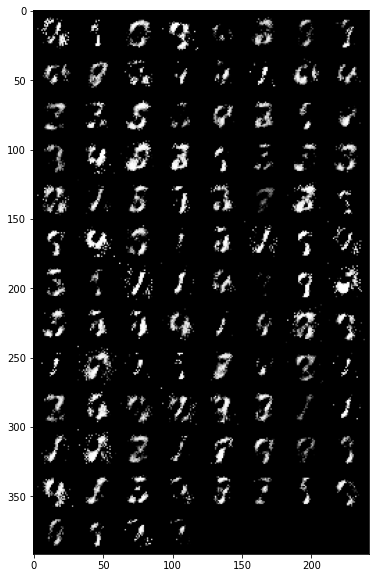

[epoch 11/200] [g_loss: 2.086770534515381 d_loss: 0.7344689965248108]
[epoch 12/200] [g_loss: 1.9506465196609497 d_loss: 0.7895277142524719]
[epoch 13/200] [g_loss: 1.8906954526901245 d_loss: 0.8105301856994629]
[epoch 14/200] [g_loss: 2.034691333770752 d_loss: 0.7770789861679077]
[epoch 15/200] [g_loss: 2.0242908000946045 d_loss: 0.75734943151474]
[epoch 16/200] [g_loss: 1.9379010200500488 d_loss: 0.8008324503898621]
[epoch 17/200] [g_loss: 1.9935141801834106 d_loss: 0.7670612335205078]
[epoch 18/200] [g_loss: 1.9729547500610352 d_loss: 0.7840259075164795]
[epoch 19/200] [g_loss: 1.8558536767959595 d_loss: 0.8395271897315979]
[epoch 20/200] [g_loss: 1.6473052501678467 d_loss: 0.8950695991516113]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


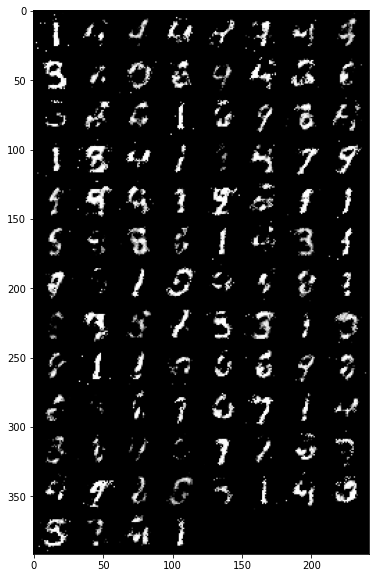

[epoch 21/200] [g_loss: 1.5265297889709473 d_loss: 0.9491153955459595]
[epoch 22/200] [g_loss: 1.5990148782730103 d_loss: 0.9364625215530396]
[epoch 23/200] [g_loss: 1.5019278526306152 d_loss: 0.9595757126808167]
[epoch 24/200] [g_loss: 1.4286301136016846 d_loss: 0.9923291802406311]
[epoch 25/200] [g_loss: 1.4811444282531738 d_loss: 0.9760181903839111]
[epoch 26/200] [g_loss: 1.4988288879394531 d_loss: 0.9636793732643127]
[epoch 27/200] [g_loss: 1.5025920867919922 d_loss: 0.9784823656082153]
[epoch 28/200] [g_loss: 1.4694212675094604 d_loss: 0.974660336971283]
[epoch 29/200] [g_loss: 1.3798948526382446 d_loss: 1.027122139930725]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



[epoch 30/200] [g_loss: 1.3839360475540161 d_loss: 1.0147452354431152]


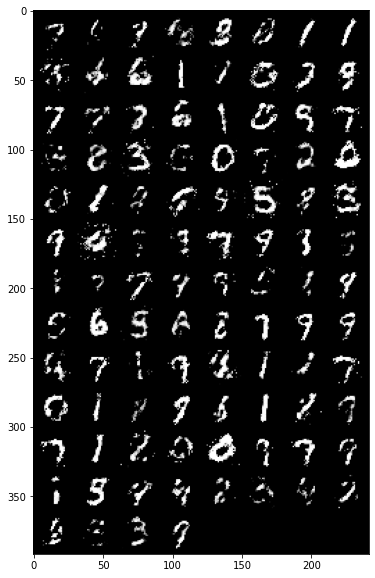

[epoch 31/200] [g_loss: 1.3599257469177246 d_loss: 1.0248833894729614]
[epoch 32/200] [g_loss: 1.3738412857055664 d_loss: 1.0228679180145264]
[epoch 33/200] [g_loss: 1.3728010654449463 d_loss: 1.026863694190979]
[epoch 34/200] [g_loss: 1.2677377462387085 d_loss: 1.068603515625]
[epoch 35/200] [g_loss: 1.2263964414596558 d_loss: 1.0840792655944824]
[epoch 36/200] [g_loss: 1.2082946300506592 d_loss: 1.1002146005630493]
[epoch 37/200] [g_loss: 1.2393896579742432 d_loss: 1.0909602642059326]
[epoch 38/200] [g_loss: 1.2889326810836792 d_loss: 1.0705493688583374]
[epoch 39/200] [g_loss: 1.2563645839691162 d_loss: 1.0764816999435425]
[epoch 40/200] [g_loss: 1.21807062625885 d_loss: 1.0974984169006348]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


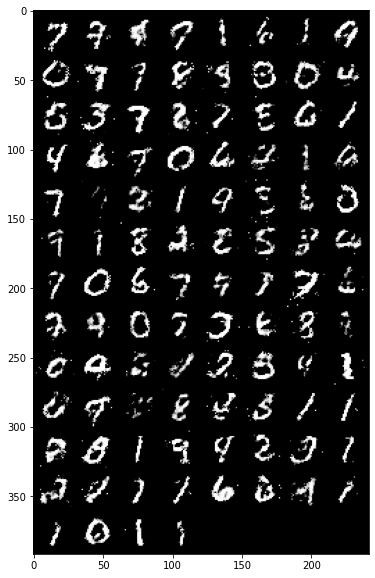

[epoch 41/200] [g_loss: 1.1960728168487549 d_loss: 1.1058026552200317]
[epoch 42/200] [g_loss: 1.1802371740341187 d_loss: 1.1174607276916504]
[epoch 43/200] [g_loss: 1.178096055984497 d_loss: 1.1269347667694092]
[epoch 44/200] [g_loss: 1.1691844463348389 d_loss: 1.124582290649414]
[epoch 45/200] [g_loss: 1.1615203619003296 d_loss: 1.1291061639785767]
[epoch 46/200] [g_loss: 1.1709823608398438 d_loss: 1.1290819644927979]
[epoch 47/200] [g_loss: 1.1664328575134277 d_loss: 1.1308236122131348]
[epoch 48/200] [g_loss: 1.1284505128860474 d_loss: 1.1497997045516968]
[epoch 49/200] [g_loss: 1.1212432384490967 d_loss: 1.157718300819397]
[epoch 50/200] [g_loss: 1.0959948301315308 d_loss: 1.157025933265686]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


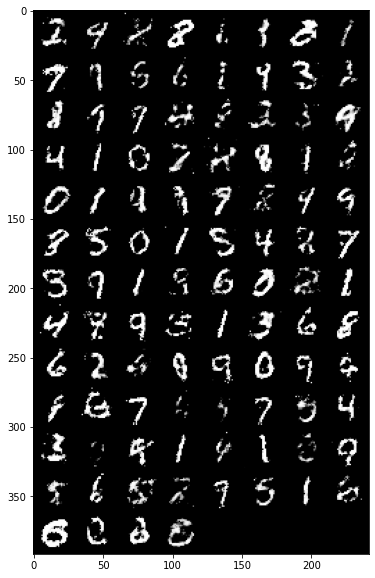

[epoch 51/200] [g_loss: 1.1117637157440186 d_loss: 1.1614761352539062]
[epoch 52/200] [g_loss: 1.0631647109985352 d_loss: 1.1770811080932617]
[epoch 53/200] [g_loss: 1.0992541313171387 d_loss: 1.1698908805847168]
[epoch 54/200] [g_loss: 1.075647234916687 d_loss: 1.1751885414123535]
[epoch 55/200] [g_loss: 1.0848370790481567 d_loss: 1.1685391664505005]
[epoch 56/200] [g_loss: 1.0415619611740112 d_loss: 1.1914191246032715]
[epoch 57/200] [g_loss: 1.0344094038009644 d_loss: 1.1971484422683716]
[epoch 58/200] [g_loss: 1.0263781547546387 d_loss: 1.1997878551483154]
[epoch 59/200] [g_loss: 1.0406478643417358 d_loss: 1.1944950819015503]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



[epoch 60/200] [g_loss: 1.0316203832626343 d_loss: 1.1967601776123047]


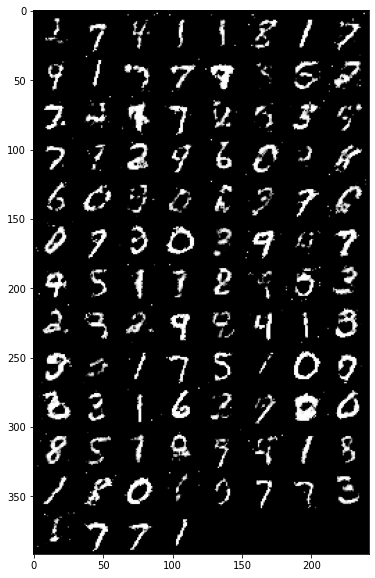

[epoch 61/200] [g_loss: 1.026138424873352 d_loss: 1.2021840810775757]
[epoch 62/200] [g_loss: 1.0160701274871826 d_loss: 1.2051953077316284]
[epoch 63/200] [g_loss: 1.0350393056869507 d_loss: 1.20319402217865]
[epoch 64/200] [g_loss: 1.042969822883606 d_loss: 1.1948521137237549]
[epoch 65/200] [g_loss: 1.0097402334213257 d_loss: 1.2120718955993652]
[epoch 66/200] [g_loss: 1.0170944929122925 d_loss: 1.2089440822601318]
[epoch 67/200] [g_loss: 1.0238512754440308 d_loss: 1.2004412412643433]
[epoch 68/200] [g_loss: 0.9942095875740051 d_loss: 1.2202544212341309]
[epoch 69/200] [g_loss: 1.008986234664917 d_loss: 1.2130719423294067]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


=
[epoch 70/200] [g_loss: 0.9965319037437439 d_loss: 1.22081458568573]


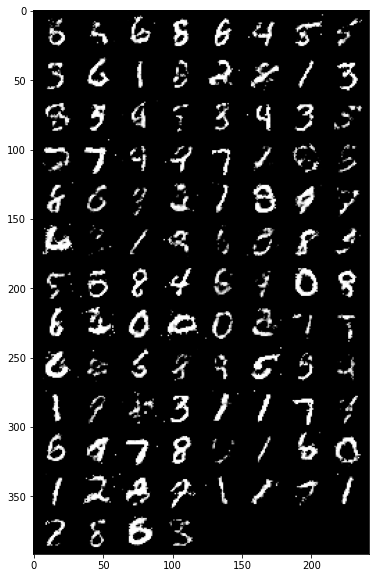

[epoch 71/200] [g_loss: 0.9950124025344849 d_loss: 1.2191506624221802]
[epoch 72/200] [g_loss: 0.9874394536018372 d_loss: 1.2231247425079346]
[epoch 73/200] [g_loss: 1.016943097114563 d_loss: 1.2107512950897217]
[epoch 74/200] [g_loss: 0.9826496243476868 d_loss: 1.2238978147506714]
[epoch 75/200] [g_loss: 0.9763986468315125 d_loss: 1.2282253503799438]
[epoch 76/200] [g_loss: 0.965147078037262 d_loss: 1.2384594678878784]
[epoch 77/200] [g_loss: 0.9808661937713623 d_loss: 1.2292498350143433]
[epoch 78/200] [g_loss: 0.9817723631858826 d_loss: 1.2261755466461182]
[epoch 79/200] [g_loss: 0.9975605010986328 d_loss: 1.2221044301986694]
[epoch 80/200] [g_loss: 1.0014468431472778 d_loss: 1.2260897159576416]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


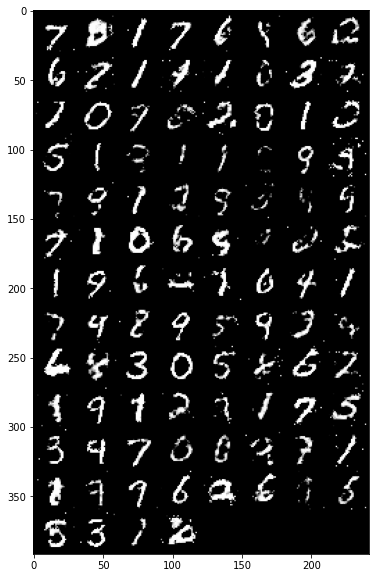

[epoch 81/200] [g_loss: 0.9906344413757324 d_loss: 1.222153902053833]
[epoch 82/200] [g_loss: 0.9683234691619873 d_loss: 1.237287998199463]
[epoch 83/200] [g_loss: 0.9700919389724731 d_loss: 1.231359839439392]
[epoch 84/200] [g_loss: 0.9492421746253967 d_loss: 1.2460501194000244]
[epoch 85/200] [g_loss: 0.9545487761497498 d_loss: 1.2410718202590942]
[epoch 86/200] [g_loss: 0.9495213627815247 d_loss: 1.247644305229187]
[epoch 87/200] [g_loss: 0.96291583776474 d_loss: 1.2439709901809692]
[epoch 88/200] [g_loss: 0.9569839239120483 d_loss: 1.2455523014068604]
[epoch 89/200] [g_loss: 0.9571881890296936 d_loss: 1.244974970817566]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


=
[epoch 90/200] [g_loss: 0.9665074944496155 d_loss: 1.2415105104446411]


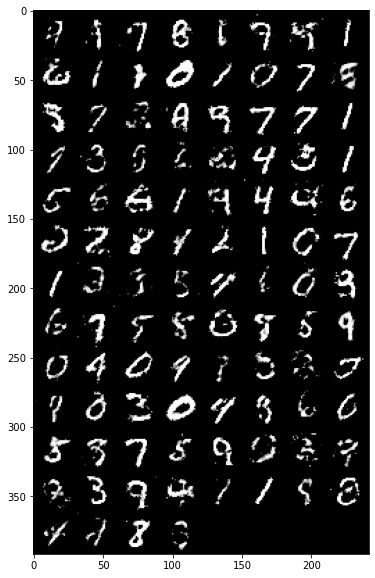

[epoch 91/200] [g_loss: 0.9507691264152527 d_loss: 1.2453598976135254]
[epoch 92/200] [g_loss: 0.9608891010284424 d_loss: 1.2455933094024658]
[epoch 93/200] [g_loss: 0.952684760093689 d_loss: 1.2529653310775757]
[epoch 94/200] [g_loss: 0.9383039474487305 d_loss: 1.2509160041809082]
[epoch 95/200] [g_loss: 0.9445347189903259 d_loss: 1.251825213432312]
[epoch 96/200] [g_loss: 0.9328445196151733 d_loss: 1.2557941675186157]
[epoch 97/200] [g_loss: 0.9393703937530518 d_loss: 1.2502914667129517]
[epoch 98/200] [g_loss: 0.9417430758476257 d_loss: 1.251680850982666]
[epoch 99/200] [g_loss: 0.9391975998878479 d_loss: 1.2576086521148682]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==
[epoch 100/200] [g_loss: 0.9260934591293335 d_loss: 1.257995843887329]


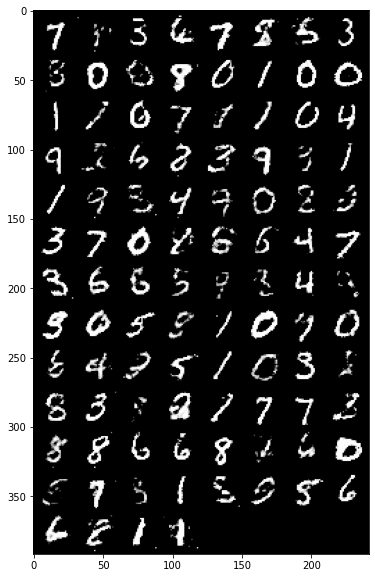

[epoch 101/200] [g_loss: 0.935097336769104 d_loss: 1.253395915031433]
[epoch 102/200] [g_loss: 0.9178717136383057 d_loss: 1.261755347251892]
[epoch 103/200] [g_loss: 0.9367915987968445 d_loss: 1.256404995918274]
[epoch 104/200] [g_loss: 0.9422751665115356 d_loss: 1.2545768022537231]
[epoch 105/200] [g_loss: 0.9348073601722717 d_loss: 1.2538378238677979]
[epoch 106/200] [g_loss: 0.9257965087890625 d_loss: 1.2593096494674683]
[epoch 107/200] [g_loss: 0.9382351636886597 d_loss: 1.2532984018325806]
[epoch 108/200] [g_loss: 0.9383655786514282 d_loss: 1.2535134553909302]
[epoch 109/200] [g_loss: 0.9436571002006531 d_loss: 1.2534427642822266]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


=
[epoch 110/200] [g_loss: 0.937157392501831 d_loss: 1.2526581287384033]


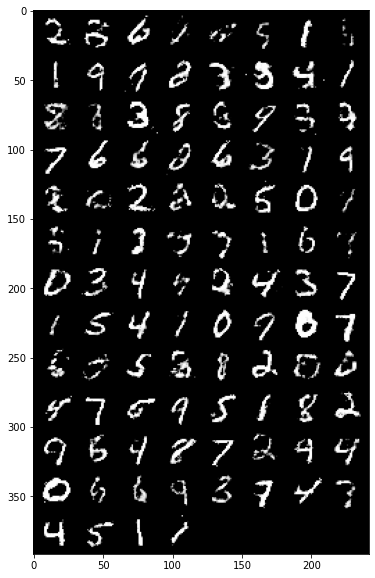

[epoch 111/200] [g_loss: 0.915457546710968 d_loss: 1.266430139541626]
[epoch 112/200] [g_loss: 0.9173259735107422 d_loss: 1.2610626220703125]
[epoch 113/200] [g_loss: 0.9306591749191284 d_loss: 1.2596149444580078]
[epoch 114/200] [g_loss: 0.915871262550354 d_loss: 1.2669862508773804]
[epoch 115/200] [g_loss: 0.9483818411827087 d_loss: 1.2497090101242065]
[epoch 116/200] [g_loss: 0.9307346343994141 d_loss: 1.2637677192687988]
[epoch 117/200] [g_loss: 0.921251118183136 d_loss: 1.2621272802352905]
[epoch 118/200] [g_loss: 0.9123339056968689 d_loss: 1.2647812366485596]
[epoch 119/200] [g_loss: 0.9211912751197815 d_loss: 1.266982078552246]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==
[epoch 120/200] [g_loss: 0.9133722186088562 d_loss: 1.265666127204895]


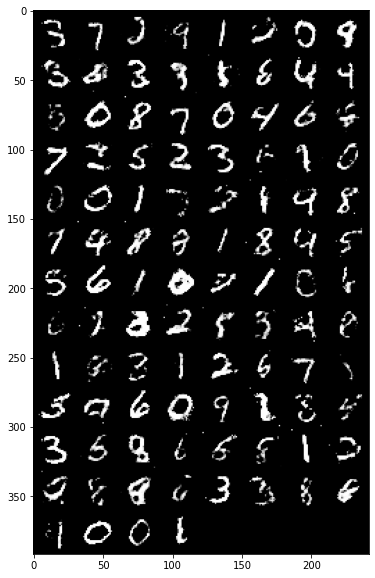

[epoch 121/200] [g_loss: 0.9114336967468262 d_loss: 1.2690280675888062]
[epoch 122/200] [g_loss: 0.9082178473472595 d_loss: 1.2724215984344482]
[epoch 123/200] [g_loss: 0.9115436673164368 d_loss: 1.2710189819335938]
[epoch 124/200] [g_loss: 0.9080735445022583 d_loss: 1.2657160758972168]
[epoch 125/200] [g_loss: 0.9081882834434509 d_loss: 1.2721412181854248]
[epoch 126/200] [g_loss: 0.9106641411781311 d_loss: 1.268798828125]
[epoch 127/200] [g_loss: 0.9090369939804077 d_loss: 1.2670297622680664]
[epoch 128/200] [g_loss: 0.9094808101654053 d_loss: 1.2689459323883057]
[epoch 129/200] [g_loss: 0.9247016310691833 d_loss: 1.2612733840942383]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


=
[epoch 130/200] [g_loss: 0.9115982055664062 d_loss: 1.2721108198165894]


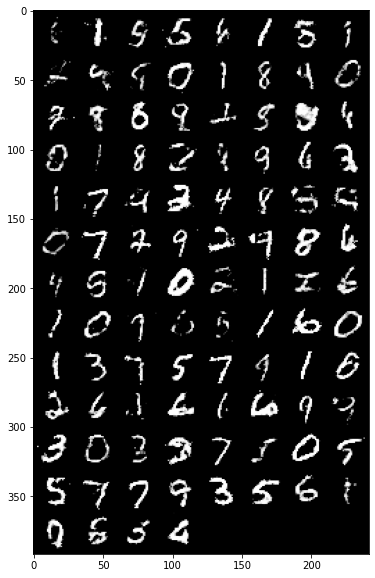

[epoch 131/200] [g_loss: 0.9009492993354797 d_loss: 1.276774287223816]
[epoch 132/200] [g_loss: 0.9040626883506775 d_loss: 1.275065302848816]
[epoch 133/200] [g_loss: 0.9057473540306091 d_loss: 1.2737222909927368]
[epoch 134/200] [g_loss: 0.9208212494850159 d_loss: 1.2657917737960815]
[epoch 135/200] [g_loss: 0.9022586941719055 d_loss: 1.2719885110855103]
[epoch 136/200] [g_loss: 0.9018937945365906 d_loss: 1.273203730583191]
[epoch 137/200] [g_loss: 0.9042683839797974 d_loss: 1.2771453857421875]
[epoch 138/200] [g_loss: 0.8962630033493042 d_loss: 1.2755711078643799]
[epoch 139/200] [g_loss: 0.9012441039085388 d_loss: 1.2759875059127808]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



[epoch 140/200] [g_loss: 0.8919740915298462 d_loss: 1.2770843505859375]


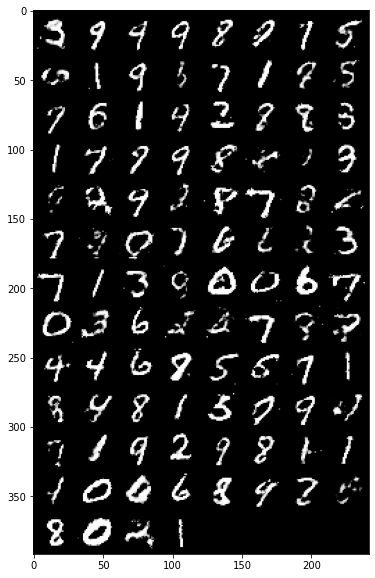

[epoch 141/200] [g_loss: 0.8980464935302734 d_loss: 1.2756693363189697]
[epoch 142/200] [g_loss: 0.9052751660346985 d_loss: 1.2728976011276245]
[epoch 143/200] [g_loss: 0.9053996801376343 d_loss: 1.2724978923797607]
[epoch 144/200] [g_loss: 0.9029510617256165 d_loss: 1.2724850177764893]
[epoch 145/200] [g_loss: 0.8906814455986023 d_loss: 1.2738392353057861]
[epoch 146/200] [g_loss: 0.9146237969398499 d_loss: 1.2726038694381714]
[epoch 147/200] [g_loss: 0.89548259973526 d_loss: 1.27846097946167]
[epoch 148/200] [g_loss: 0.9106639623641968 d_loss: 1.2731250524520874]
[epoch 149/200] [g_loss: 0.8917538523674011 d_loss: 1.2798569202423096]
[epoch 150/200] [g_loss: 0.8808041214942932 d_loss: 1.2833340167999268]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


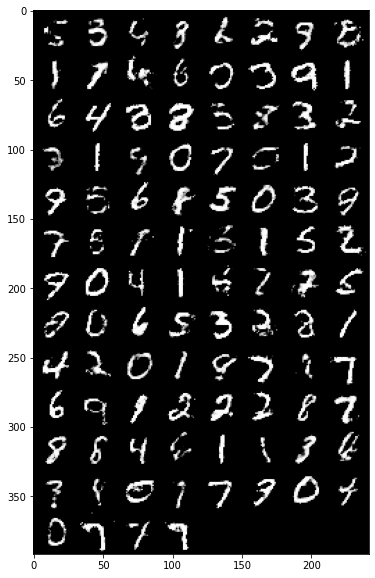

[epoch 151/200] [g_loss: 0.8832259178161621 d_loss: 1.2807738780975342]
[epoch 152/200] [g_loss: 0.906447172164917 d_loss: 1.2752083539962769]
[epoch 153/200] [g_loss: 0.8833927512168884 d_loss: 1.2848881483078003]
[epoch 154/200] [g_loss: 0.9019180536270142 d_loss: 1.2797555923461914]
[epoch 155/200] [g_loss: 0.8922408223152161 d_loss: 1.276749610900879]
[epoch 156/200] [g_loss: 0.890957772731781 d_loss: 1.2772561311721802]
[epoch 157/200] [g_loss: 0.887596845626831 d_loss: 1.2790995836257935]
[epoch 158/200] [g_loss: 0.8763865232467651 d_loss: 1.284184217453003]
[epoch 159/200] [g_loss: 0.8961834907531738 d_loss: 1.2806243896484375]
[epoch 160/200] [g_loss: 0.8910186886787415 d_loss: 1.2808290719985962]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


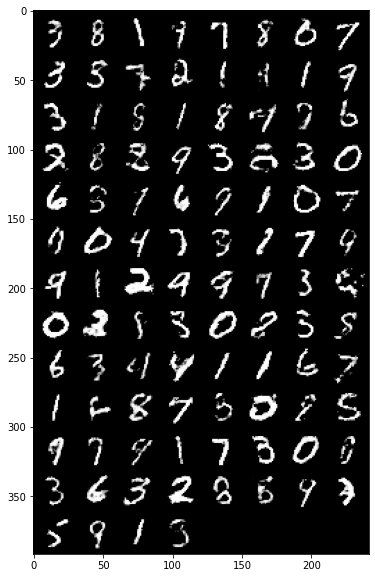

[epoch 161/200] [g_loss: 0.8996029496192932 d_loss: 1.2795964479446411]
[epoch 162/200] [g_loss: 0.8791574835777283 d_loss: 1.2863003015518188]
[epoch 163/200] [g_loss: 0.8947179317474365 d_loss: 1.2825618982315063]
[epoch 164/200] [g_loss: 0.8859639763832092 d_loss: 1.284656047821045]
[epoch 165/200] [g_loss: 0.8813380002975464 d_loss: 1.2855780124664307]
[epoch 166/200] [g_loss: 0.8906192183494568 d_loss: 1.2817916870117188]
[epoch 167/200] [g_loss: 0.8921239376068115 d_loss: 1.2787067890167236]
[epoch 168/200] [g_loss: 0.8742256760597229 d_loss: 1.2903536558151245]
[epoch 169/200] [g_loss: 0.8855873346328735 d_loss: 1.2809157371520996]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



[epoch 170/200] [g_loss: 0.8862518072128296 d_loss: 1.2835266590118408]


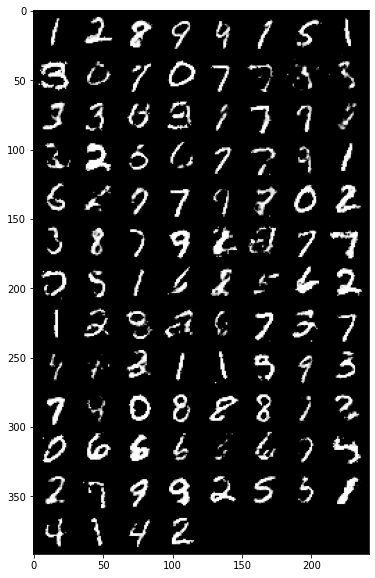

[epoch 171/200] [g_loss: 0.891427218914032 d_loss: 1.2793362140655518]
[epoch 172/200] [g_loss: 0.8864660859107971 d_loss: 1.280799388885498]
[epoch 173/200] [g_loss: 0.8812662959098816 d_loss: 1.2820879220962524]
[epoch 174/200] [g_loss: 0.8734500408172607 d_loss: 1.2860878705978394]
[epoch 175/200] [g_loss: 0.886330783367157 d_loss: 1.2856067419052124]
[epoch 176/200] [g_loss: 0.8792697191238403 d_loss: 1.2845370769500732]
[epoch 177/200] [g_loss: 0.8849992752075195 d_loss: 1.2846585512161255]
[epoch 178/200] [g_loss: 0.8753722906112671 d_loss: 1.2853422164916992]
[epoch 179/200] [g_loss: 0.8706804513931274 d_loss: 1.290155291557312]
[epoch 180/200] [g_loss: 0.8893426656723022 d_loss: 1.2846754789352417]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


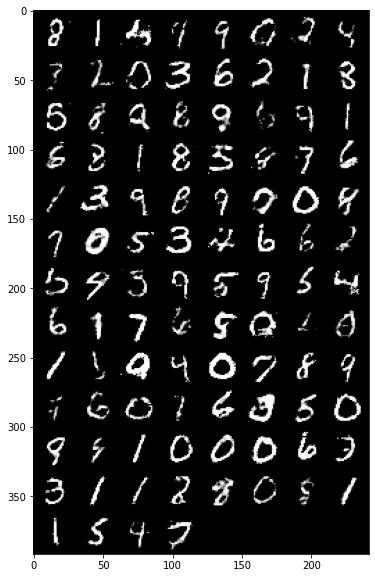

[epoch 181/200] [g_loss: 0.887820303440094 d_loss: 1.2823309898376465]
[epoch 182/200] [g_loss: 0.8761966228485107 d_loss: 1.2862927913665771]
[epoch 183/200] [g_loss: 0.8833363652229309 d_loss: 1.2849030494689941]
[epoch 184/200] [g_loss: 0.8901004791259766 d_loss: 1.2815150022506714]
[epoch 185/200] [g_loss: 0.8801508545875549 d_loss: 1.2862871885299683]
[epoch 186/200] [g_loss: 0.8774455785751343 d_loss: 1.2904908657073975]
[epoch 187/200] [g_loss: 0.8716609477996826 d_loss: 1.2906123399734497]
[epoch 188/200] [g_loss: 0.877169668674469 d_loss: 1.2911401987075806]
[epoch 189/200] [g_loss: 0.8729069828987122 d_loss: 1.2850220203399658]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


=
[epoch 190/200] [g_loss: 0.8810060620307922 d_loss: 1.2871990203857422]


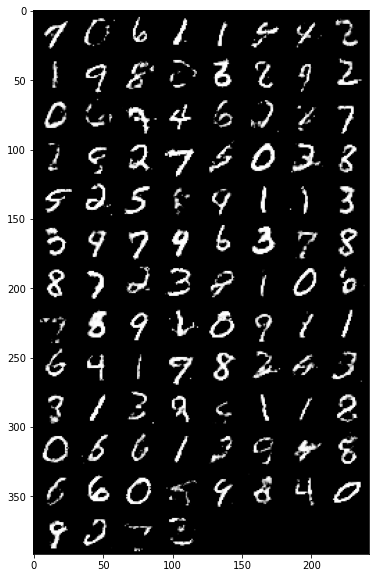

[epoch 191/200] [g_loss: 0.8773192167282104 d_loss: 1.286004900932312]
[epoch 192/200] [g_loss: 0.8793661594390869 d_loss: 1.289535403251648]
[epoch 193/200] [g_loss: 0.8855321407318115 d_loss: 1.2818629741668701]
[epoch 194/200] [g_loss: 0.8791155815124512 d_loss: 1.2878608703613281]
[epoch 195/200] [g_loss: 0.8837882280349731 d_loss: 1.2850733995437622]
[epoch 196/200] [g_loss: 0.8724097609519958 d_loss: 1.2901699542999268]
[epoch 197/200] [g_loss: 0.8668807744979858 d_loss: 1.2932733297348022]
[epoch 198/200] [g_loss: 0.8790833353996277 d_loss: 1.2851101160049438]
[epoch 199/200] [g_loss: 0.8771031498908997 d_loss: 1.2884154319763184]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


=
[epoch 200/200] [g_loss: 0.8828697800636292 d_loss: 1.2802140712738037]


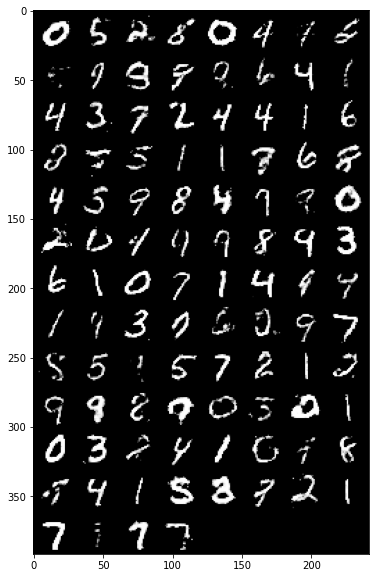

In [26]:
g,d = train(200)

#Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


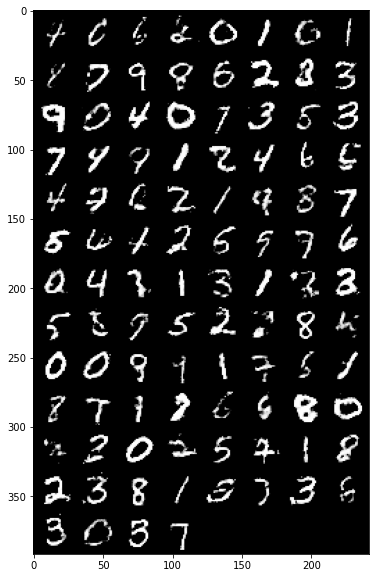

Images of MNIST numbers generated by computer


In [31]:
x_test = torch.randn((100,100)).to(device)
generator.eval()
with torch.no_grad():
  pred_img = generator(x_test)
  show_img_grid(pred_img.reshape(100,1,28,28).cpu().detach())
  print("Images of MNIST numbers generated by computer")

##Plotting losses(ie. generator loss and dicriminator loss)

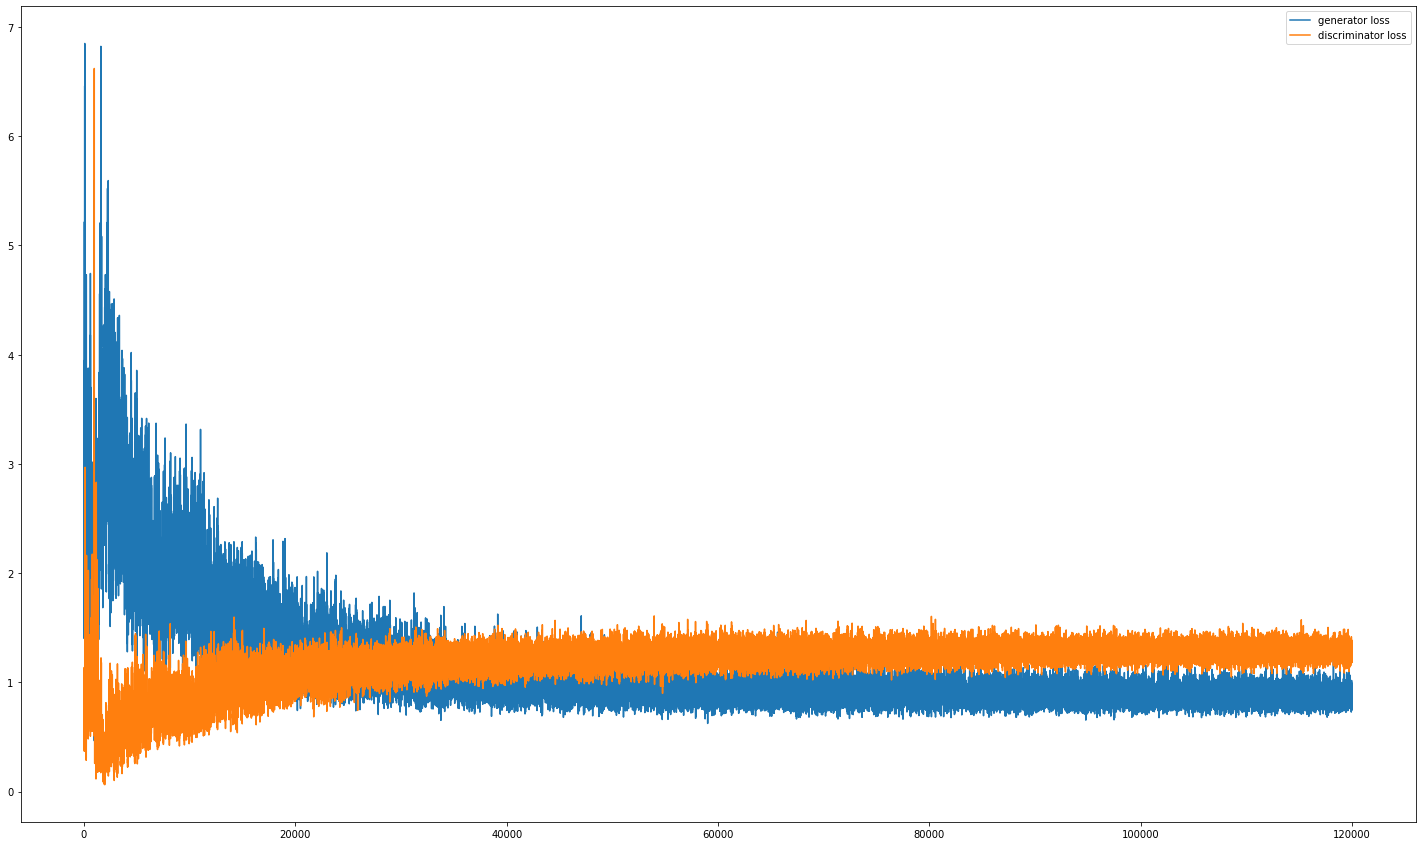

In [30]:
plt.figure(figsize=(25,15))

plt.plot(g,label='generator loss')
plt.plot(d,label='discriminator loss')
plt.legend()
plt.show()